# Advanced Pairs Trading : Kalman Filters

## Import library

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
import statsmodels.api as sm
import quantstats as qs
import numpy as np
from pykalman import KalmanFilter
import pandas as pd
import matplotlib.pyplot as plt
from Kalman_Filter import Kalman_Filter

## Getting the Data

In [3]:
XAUUSD = load_data()

## Class Kalman Filter

## XAUUSD & USDJPY

In [4]:
Currency_Pair = 'USDJPY'

## TF D1

In [5]:
TF = 'D1'

In [6]:
data_1 = XAUUSD[TF]

In [7]:
data_2 = pd.read_csv(
    PATH_DATA + f'/{Currency_Pair}/{Currency_Pair}_{TF} - {Currency_Pair}_{TF}' + '.csv', index_col='Time', parse_dates=True)

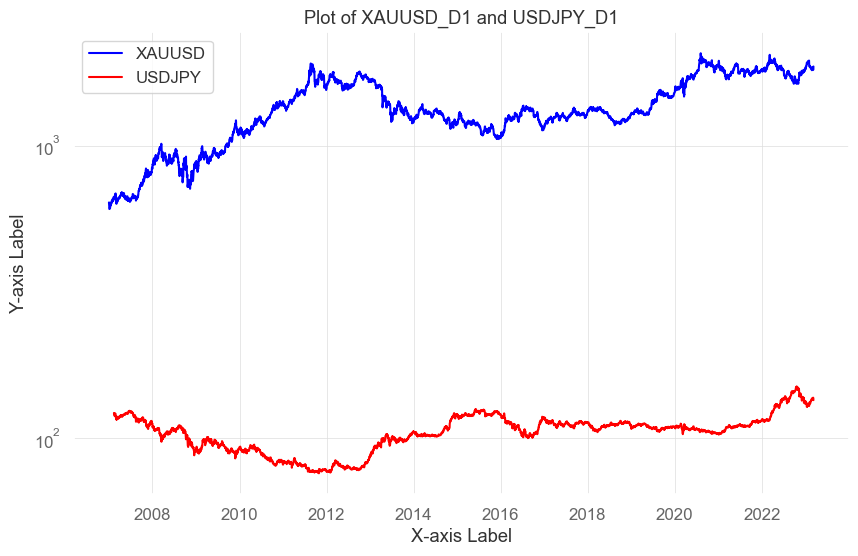

In [8]:
plt.figure(figsize=(10, 6))

# พล็อตข้อมูลใน data_1
plt.plot(data_1.index, data_1['Close'], label='XAUUSD', color='blue')
plt.yscale('log')  # ใช้ค่าลอการิทึมในแกน y

# พล็อตข้อมูลใน data_2
plt.plot(data_2.index, data_2['Close'], label=f'{Currency_Pair}', color='red')
plt.yscale('log')  # ใช้ค่าลอการิทึมในแกน y

# เพิ่มคำอธิบายแต่ละแท่งของกราฟ
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title(f'Plot of XAUUSD_{TF} and {Currency_Pair}_{TF}')
plt.legend()

# แสดงกราฟ
plt.show()

In [9]:
KF = Kalman_Filter(data_1, data_2)

In [10]:
KF.Stat()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Close   R-squared (uncentered):                   0.922
Model:                            OLS   Adj. R-squared (uncentered):              0.922
Method:                 Least Squares   F-statistic:                          5.972e+04
Date:                Sat, 02 Mar 2024   Prob (F-statistic):                        0.00
Time:                        17:44:10   Log-Likelihood:                         -37037.
No. Observations:                5021   AIC:                                  7.408e+04
Df Residuals:                    5020   BIC:                                  7.408e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Close         12.5893      0.052    244.371      0.000      12.488      12.690
==============================================================================
Omnibus:                       64.002   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.023
Skew:                          -0.016   Prob(JB):                     3.36e-09
Kurtosis:                       2.569   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
result = KF.Run()

### Save Result Backtest 

In [12]:
result
data = result[['strategy', 'stock1_signal', 'stock2_signal']].copy()

In [13]:
filename = f'{Currency_Pair}_{TF}.csv'

In [14]:
data.to_csv(
    f'../../out/Pairs_Trading/Kalman Filter/Backtest/{filename}', index=True)

### Reports

                           Strategy
-------------------------  ----------
Start Period               2007-02-12
End Period                 2023-03-10
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          -100.0%
CAGR﹪                     -35.08%

Sharpe                     -1.24
Prob. Sharpe Ratio         0.0%
Smart Sharpe               -1.07
Sortino                    -1.34
Smart Sortino              -1.16
Sortino/√2                 -0.95
Smart Sortino/√2           -0.82
Omega                      0.71

Max Drawdown               -100.0%
Longest DD Days            5735
Volatility (ann.)          35.16%
Calmar                     -0.35
Skew                       -6.64
Kurtosis                   64.04

Expected Daily %           -0.2%
Expected Monthly %         -5.05%
Expected Yearly %          -44.67%
Kelly Criterion            -19.75%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.82%
Expected Shortfall (cVaR)  -3.82%

Max Consecu

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-06-28,2022-10-20,2023-03-10,5735,-99.996715,-99.996385
2,2007-02-13,2007-04-20,2007-05-23,100,-7.319826,-7.254318
3,2007-05-28,2007-06-06,2007-06-07,11,-2.841693,-2.580292
4,2007-06-17,2007-06-19,2007-06-19,3,-0.895801,-0.160189
5,2007-06-11,2007-06-11,2007-06-12,2,-0.748181,-0.023089


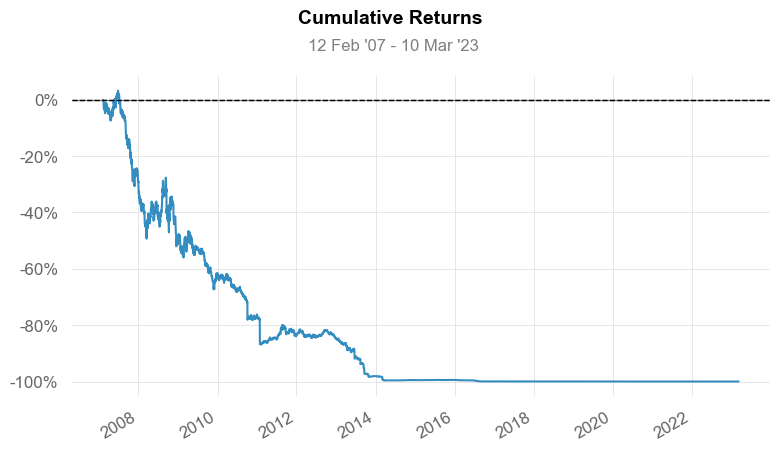

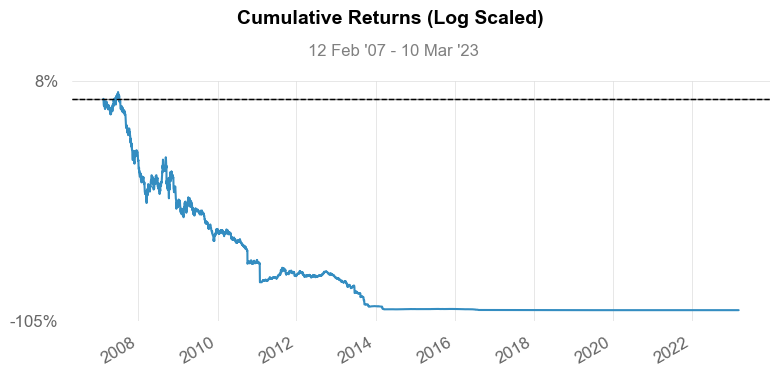

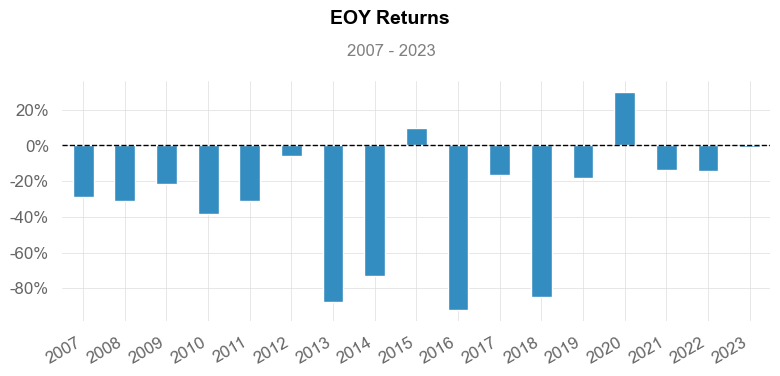

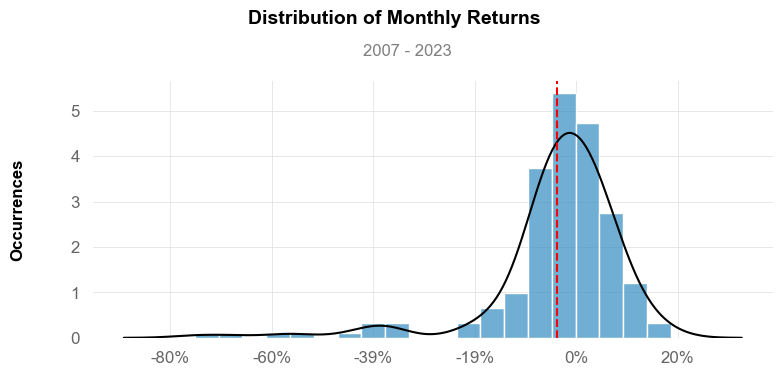

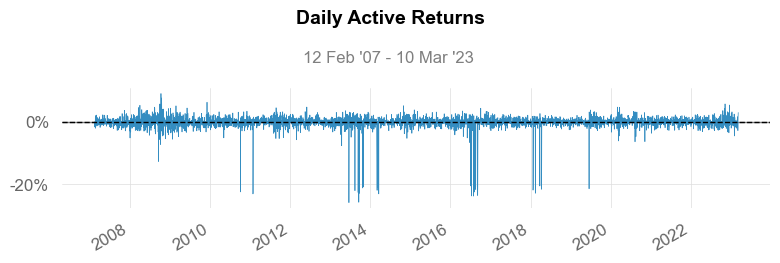

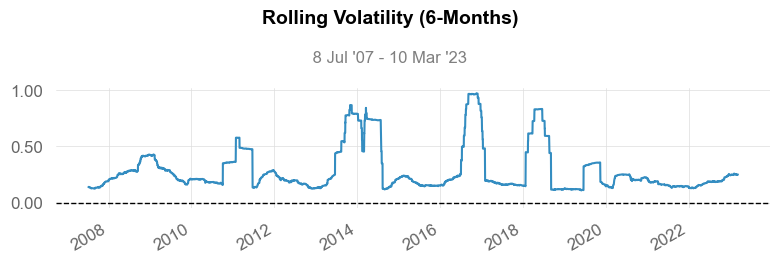

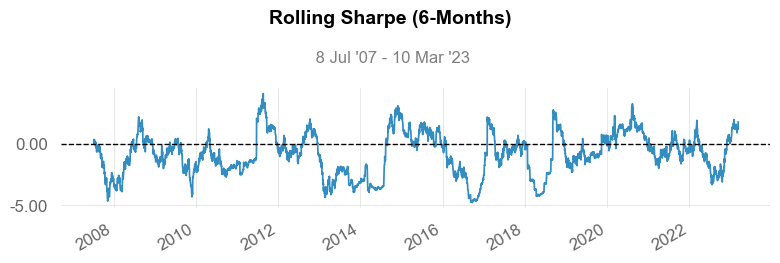

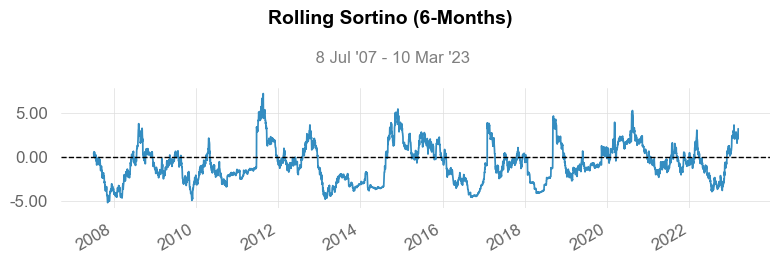

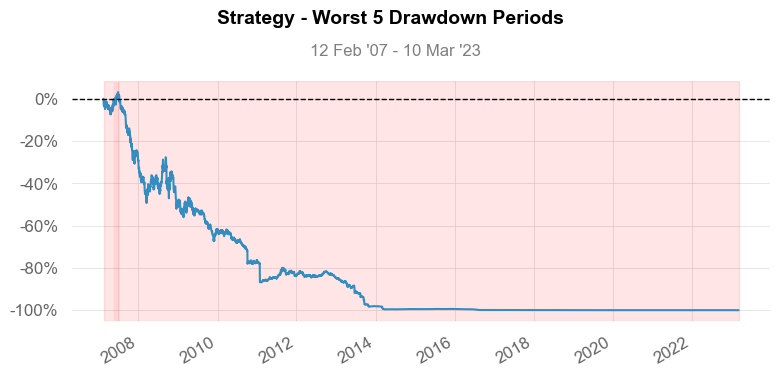

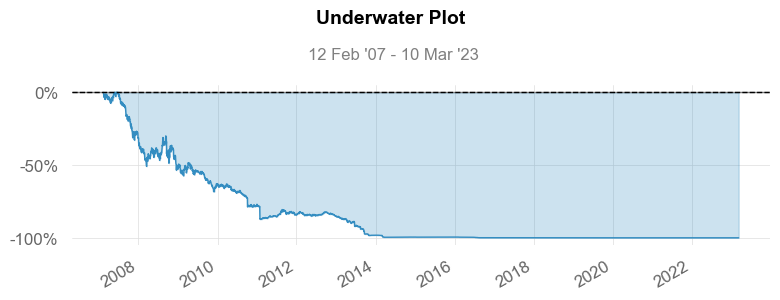

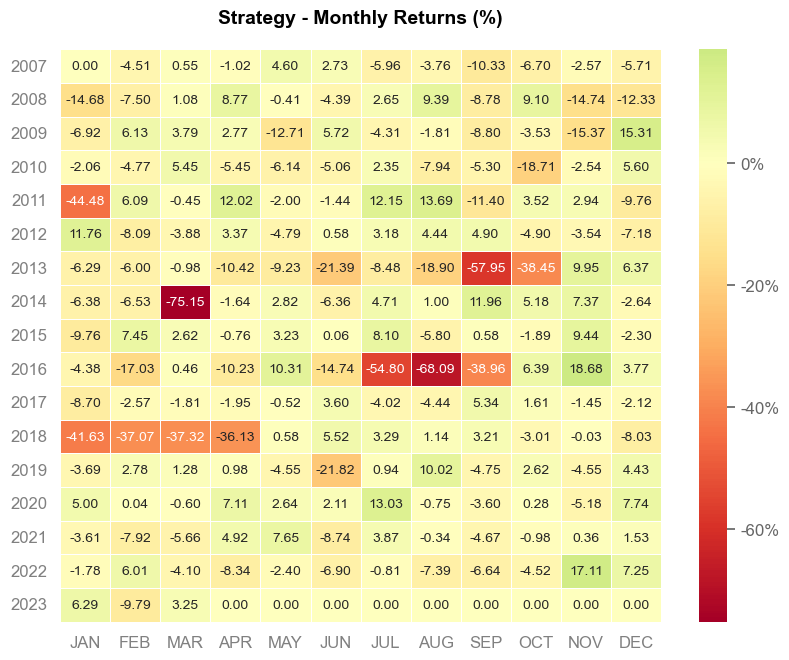

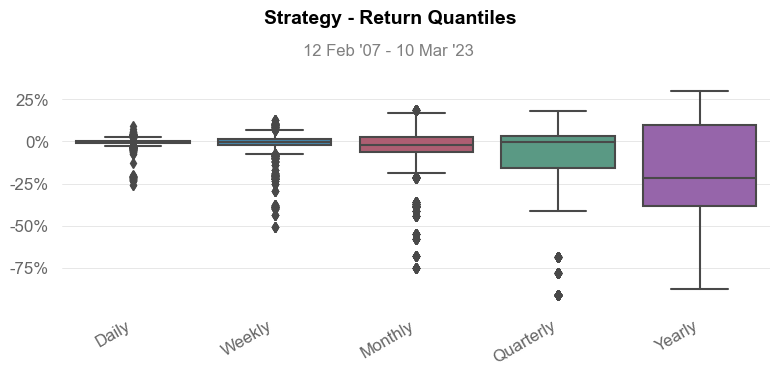

In [15]:
qs.reports.full(result['returns_all'].resample('D').last().dropna())

## TF H4

In [16]:
TF = 'H4'

In [17]:
data_1 = XAUUSD[TF]

In [18]:
data_2 = pd.read_csv(
    PATH_DATA + f'/{Currency_Pair}/{Currency_Pair}_{TF} - {Currency_Pair}_{TF}' + '.csv', index_col='Time', parse_dates=True)

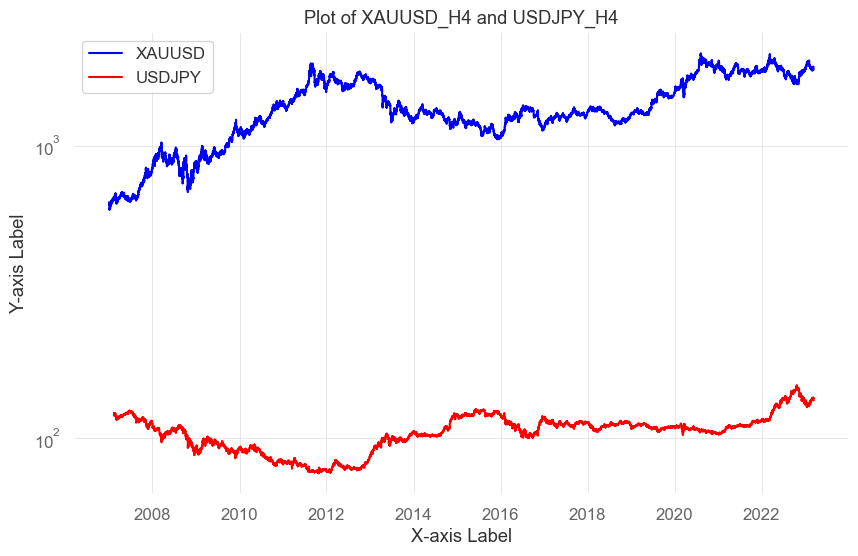

In [19]:
plt.figure(figsize=(10, 6))

# พล็อตข้อมูลใน data_1
plt.plot(data_1.index, data_1['Close'], label='XAUUSD', color='blue')
plt.yscale('log')  # ใช้ค่าลอการิทึมในแกน y

# พล็อตข้อมูลใน data_2
plt.plot(data_2.index, data_2['Close'], label=f'{Currency_Pair}', color='red')
plt.yscale('log')  # ใช้ค่าลอการิทึมในแกน y

# เพิ่มคำอธิบายแต่ละแท่งของกราฟ
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title(f'Plot of XAUUSD_{TF} and {Currency_Pair}_{TF}')
plt.legend()

# แสดงกราฟ
plt.show()

In [20]:
KF = Kalman_Filter(data_1, data_2)

In [21]:
KF.Stat()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Close   R-squared (uncentered):                   0.922
Model:                            OLS   Adj. R-squared (uncentered):              0.922
Method:                 Least Squares   F-statistic:                          3.077e+05
Date:                Sat, 02 Mar 2024   Prob (F-statistic):                        0.00
Time:                        17:45:54   Log-Likelihood:                     -1.9080e+05
No. Observations:               25865   AIC:                                  3.816e+05
Df Residuals:                   25864   BIC:                                  3.816e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Close         12.5919      0.023    554.666      0.000      12.547      12.636
==============================================================================
Omnibus:                      332.140   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              200.785
Skew:                          -0.017   Prob(JB):                     2.51e-44
Kurtosis:                       2.570   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
result = KF.Run()

### Save Result Backtest 

In [23]:
result
data = result[['strategy', 'stock1_signal', 'stock2_signal']].copy()

In [24]:
filename = f'{Currency_Pair}_{TF}.csv'

In [25]:
data.to_csv(
    f'../../out/Pairs_Trading/Kalman Filter/Backtest/{filename}', index=True)

### Reports

                           Strategy
-------------------------  ----------
Start Period               2007-02-12
End Period                 2023-03-10
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          -75.68%
CAGR﹪                     -5.89%

Sharpe                     -0.62
Prob. Sharpe Ratio         0.0%
Smart Sharpe               -0.61
Sortino                    -0.66
Smart Sortino              -0.65
Sortino/√2                 -0.46
Smart Sortino/√2           -0.46
Omega                      0.79

Max Drawdown               -80.84%
Longest DD Days            5851
Volatility (ann.)          10.47%
Calmar                     -0.07
Skew                       -23.4
Kurtosis                   720.56

Expected Daily %           -0.03%
Expected Monthly %         -0.73%
Expected Yearly %          -7.98%
Kelly Criterion            -12.85%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.11%
Expected Shortfall (cVaR)  -1.11%

Max Consecu

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-03-04,2019-06-02,2023-03-10,5851,-80.843951,-80.515818
2,2007-02-14,2007-02-14,2007-02-15,2,-0.389232,-0.186032
3,2007-02-23,2007-02-25,2007-02-26,4,-0.197012,-0.137665
4,2007-02-28,2007-02-28,2007-02-28,1,-0.173657,NaN
5,2007-02-20,2007-02-20,2007-02-20,1,-0.098408,NaN


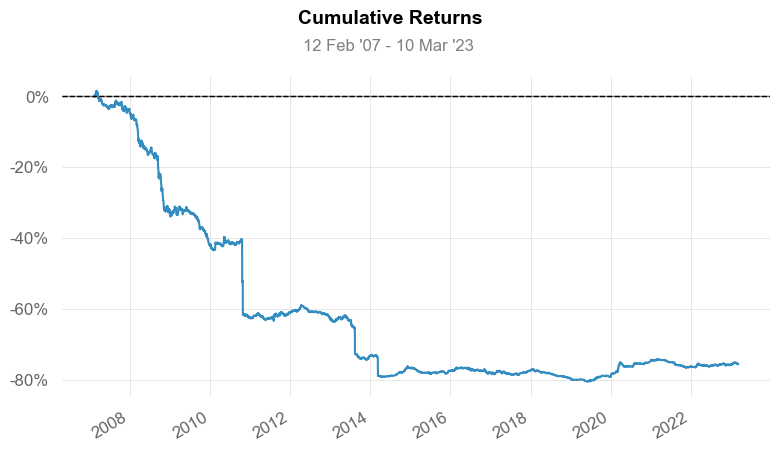

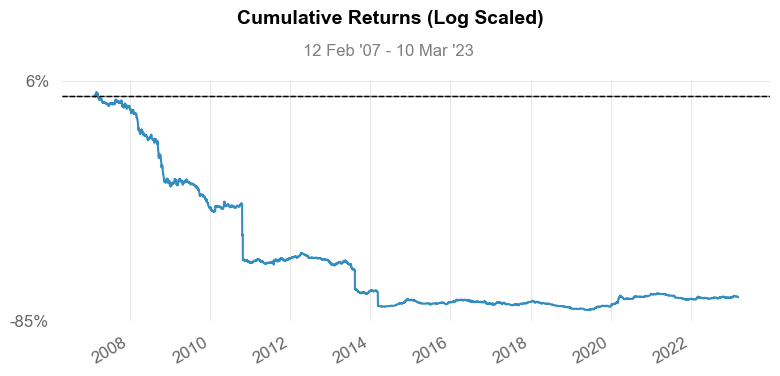

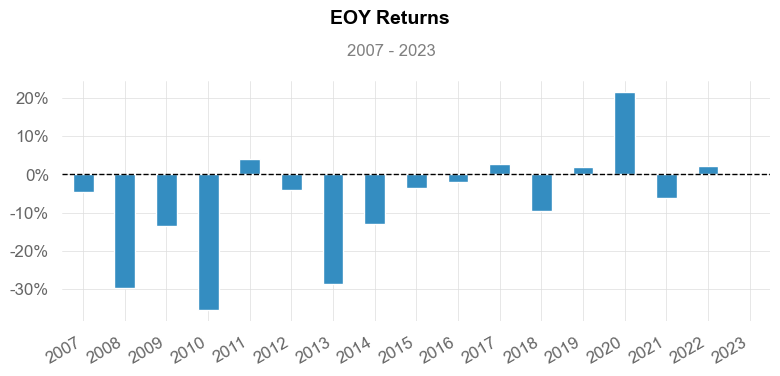

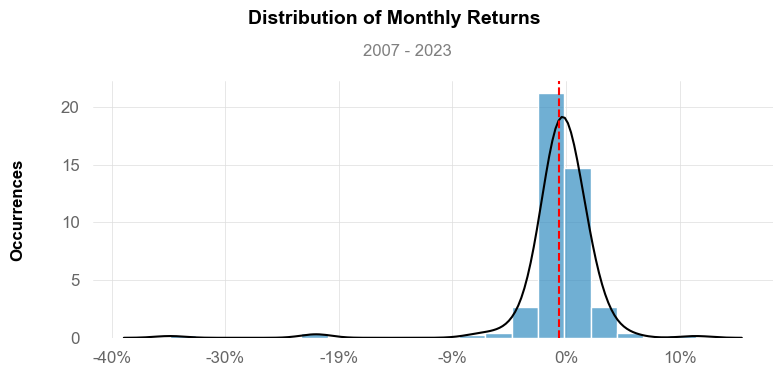

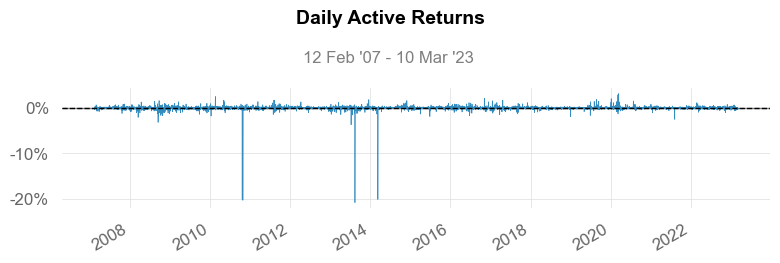

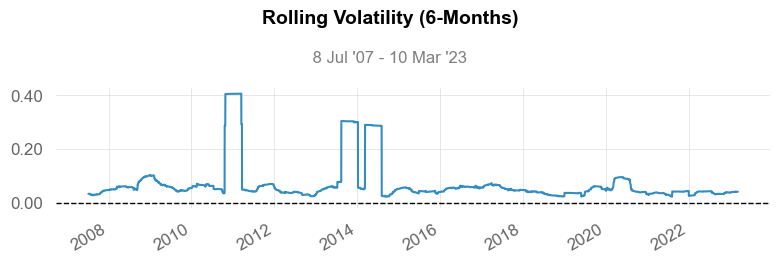

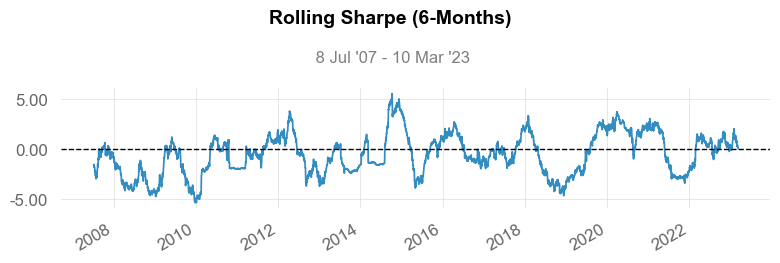

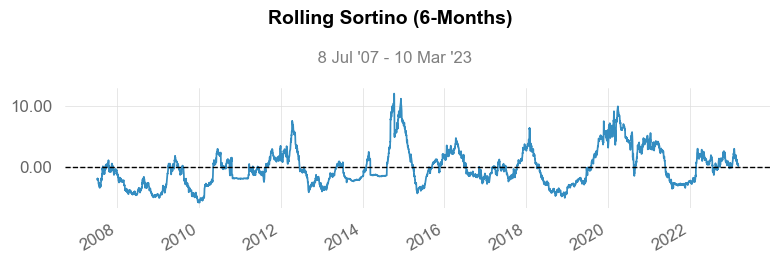

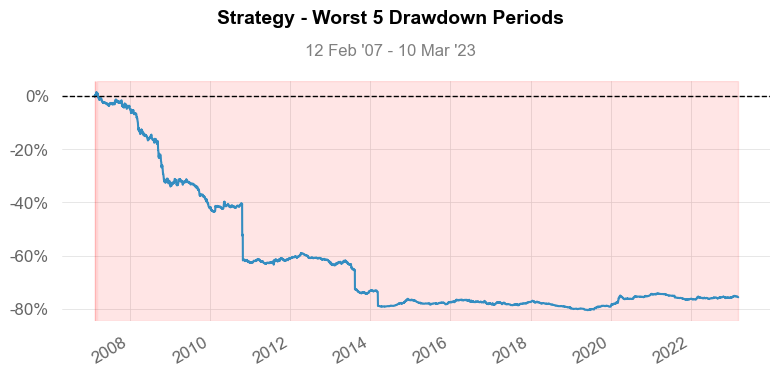

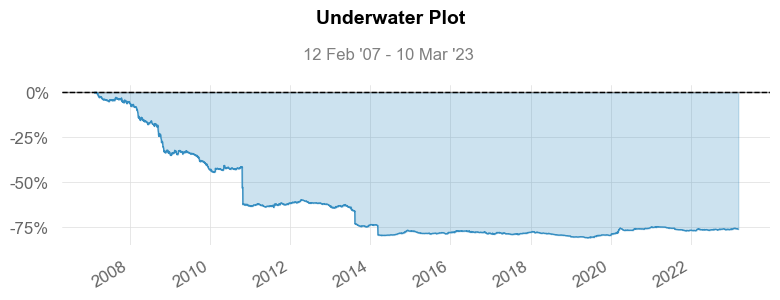

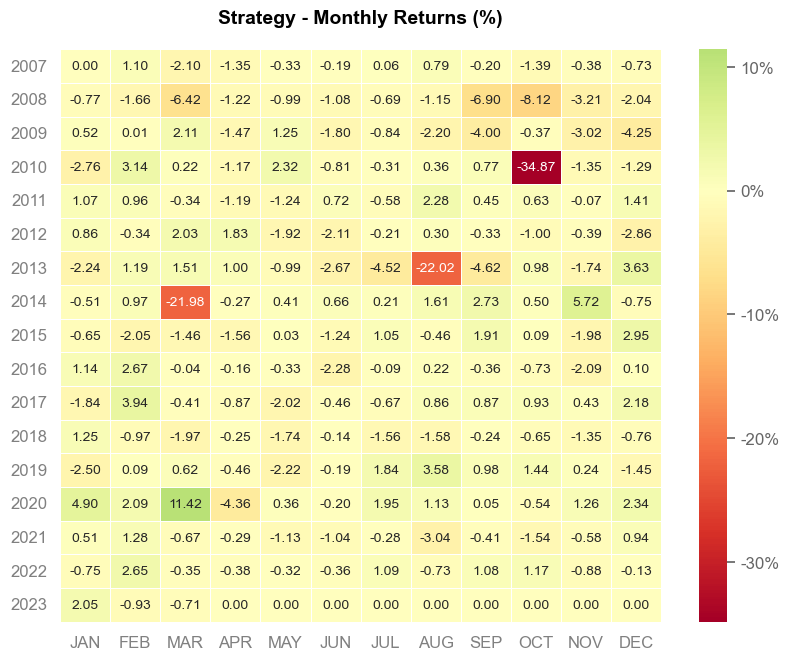

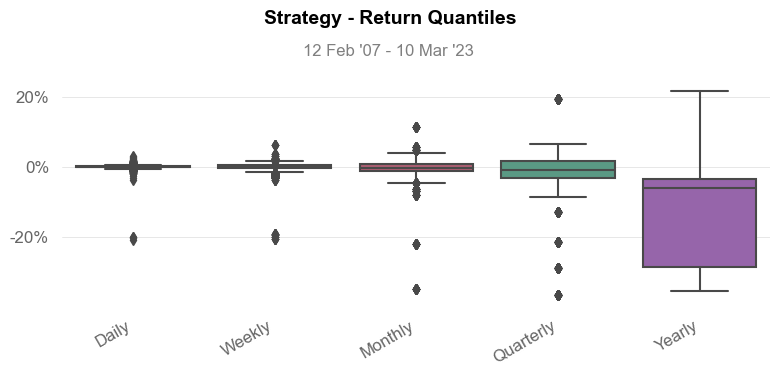

In [26]:
qs.reports.full(result['returns_all'].resample('D').last().dropna())

## TF H1

In [27]:
TF = 'H1'

In [28]:
data_1 = XAUUSD[TF]

In [29]:
data_2 = pd.read_csv(
    PATH_DATA + f'/{Currency_Pair}/{Currency_Pair}_{TF} - {Currency_Pair}_{TF}' + '.csv', index_col='Time', parse_dates=True)

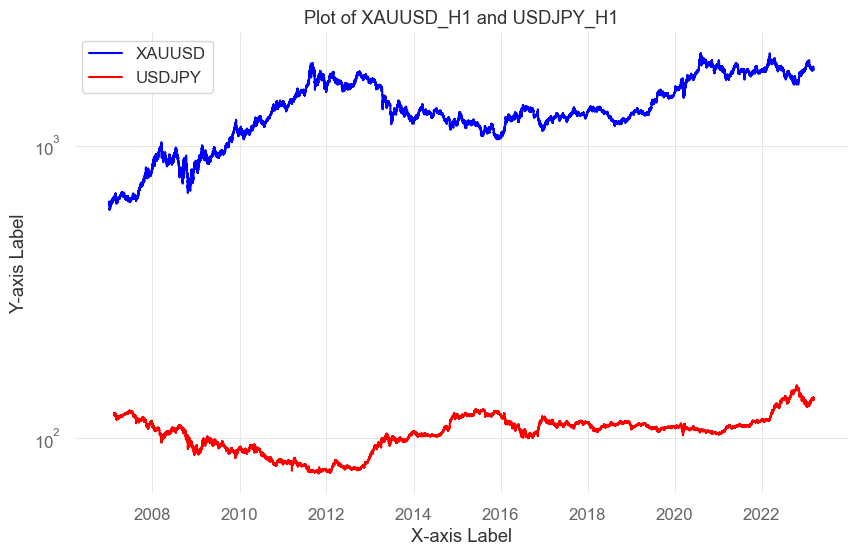

In [30]:
plt.figure(figsize=(10, 6))

# พล็อตข้อมูลใน data_1
plt.plot(data_1.index, data_1['Close'], label='XAUUSD', color='blue')
plt.yscale('log')  # ใช้ค่าลอการิทึมในแกน y

# พล็อตข้อมูลใน data_2
plt.plot(data_2.index, data_2['Close'], label=f'{Currency_Pair}', color='red')
plt.yscale('log')  # ใช้ค่าลอการิทึมในแกน y

# เพิ่มคำอธิบายแต่ละแท่งของกราฟ
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title(f'Plot of XAUUSD_{TF} and {Currency_Pair}_{TF}')
plt.legend()

# แสดงกราฟ
plt.show()

In [31]:
KF = Kalman_Filter(data_1, data_2)

In [32]:
KF.Stat()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Close   R-squared (uncentered):                   0.922
Model:                            OLS   Adj. R-squared (uncentered):              0.922
Method:                 Least Squares   F-statistic:                          1.190e+06
Date:                Sat, 02 Mar 2024   Prob (F-statistic):                        0.00
Time:                        17:50:15   Log-Likelihood:                     -7.3785e+05
No. Observations:              100026   AIC:                                  1.476e+06
Df Residuals:                  100025   BIC:                                  1.476e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Close         12.5923      0.012   1090.876      0.000      12.570      12.615
==============================================================================
Omnibus:                     1284.197   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              775.577
Skew:                          -0.018   Prob(JB):                    3.85e-169
Kurtosis:                       2.570   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
result = KF.Run()

### Save Result Backtest 

In [34]:
result
data = result[['strategy', 'stock1_signal', 'stock2_signal']].copy()

In [35]:
filename = f'{Currency_Pair}_{TF}.csv'

In [36]:
data.to_csv(
    f'../../out/Pairs_Trading/Kalman Filter/Backtest/{filename}', index=True)

### Reports

                           Strategy
-------------------------  ----------
Start Period               2007-02-12
End Period                 2023-03-10
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          -74.61%
CAGR﹪                     -5.72%

Sharpe                     -0.52
Prob. Sharpe Ratio         0.0%
Smart Sharpe               -0.52
Sortino                    -0.53
Smart Sortino              -0.53
Sortino/√2                 -0.38
Smart Sortino/√2           -0.38
Omega                      0.74

Max Drawdown               -83.81%
Longest DD Days            5592
Volatility (ann.)          11.67%
Calmar                     -0.07
Skew                       -25.55
Kurtosis                   706.79

Expected Daily %           -0.03%
Expected Monthly %         -0.7%
Expected Yearly %          -7.75%
Kelly Criterion            -17.74%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.23%
Expected Shortfall (cVaR)  -1.23%

Max Consecu

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-11-18,2019-06-02,2023-03-10,5592,-83.806853,-83.725755
2,2007-02-25,2007-06-26,2007-07-25,151,-1.383217,-1.275470
3,2007-08-28,2007-09-03,2007-09-13,17,-0.632955,-0.626209
4,2007-10-17,2007-10-28,2007-11-06,21,-0.592160,-0.516588
5,2007-08-09,2007-08-10,2007-08-17,9,-0.507628,-0.495408


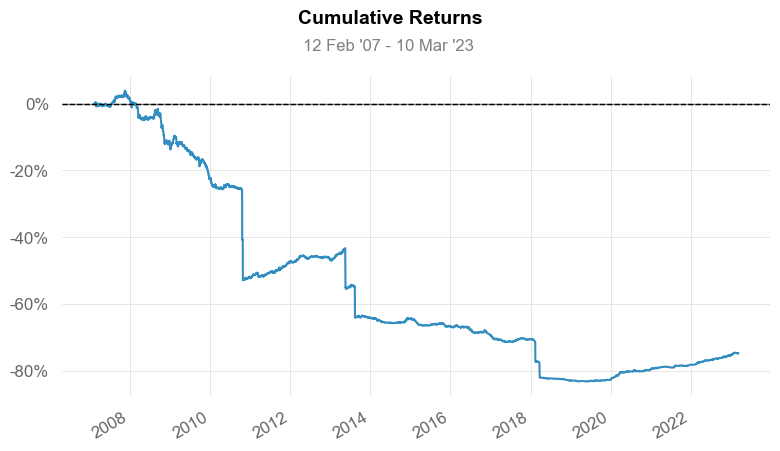

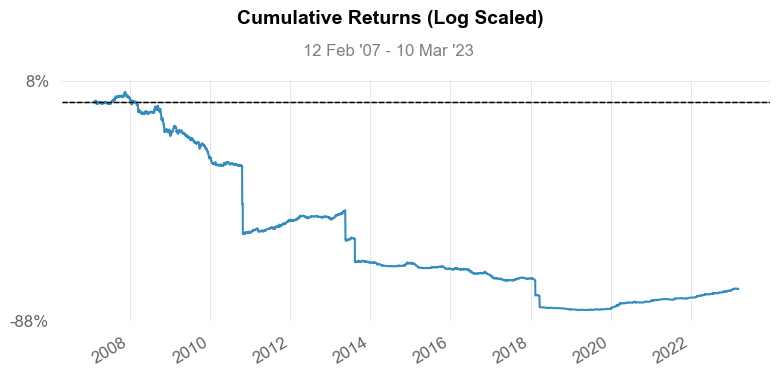

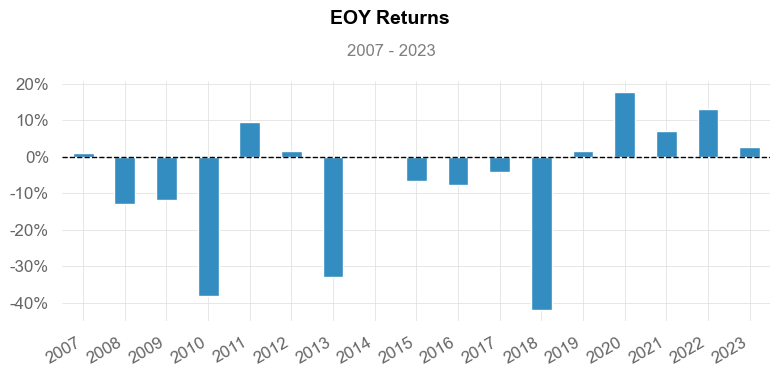

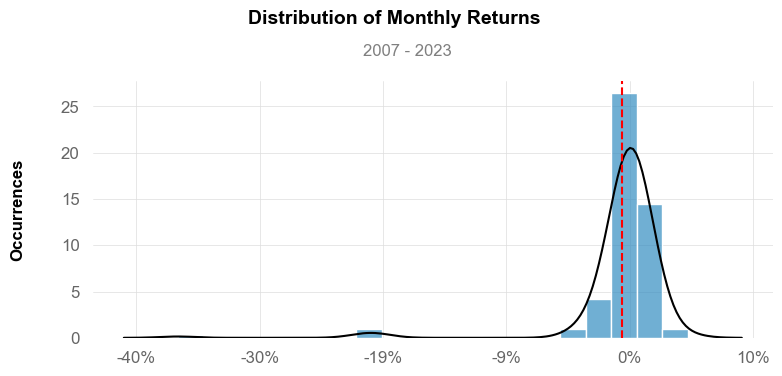

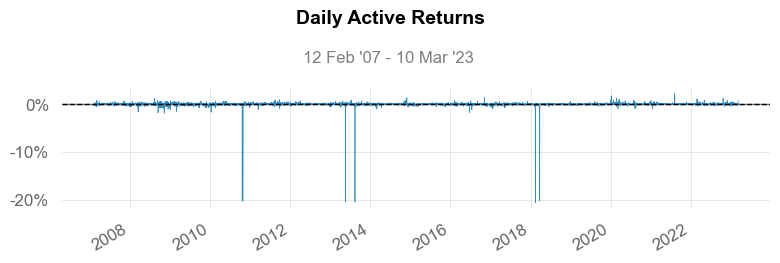

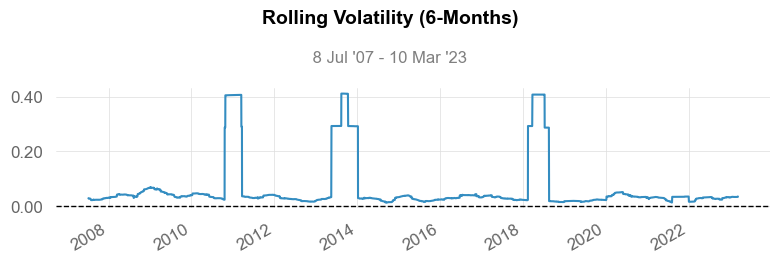

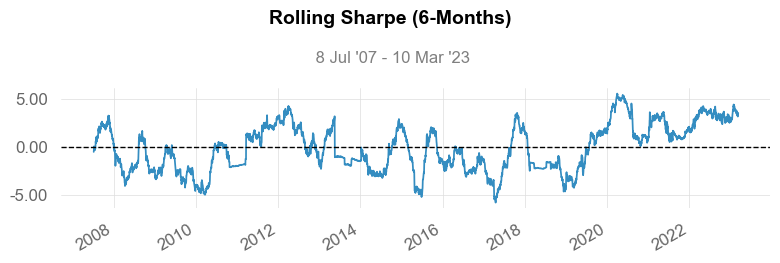

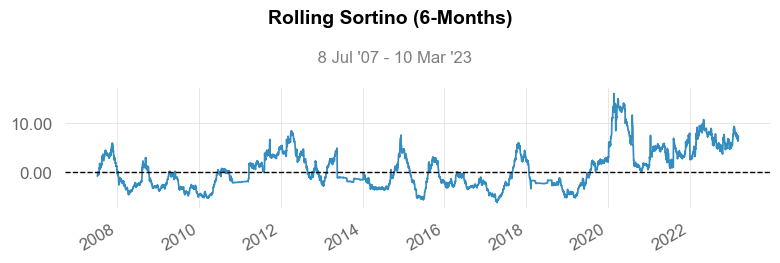

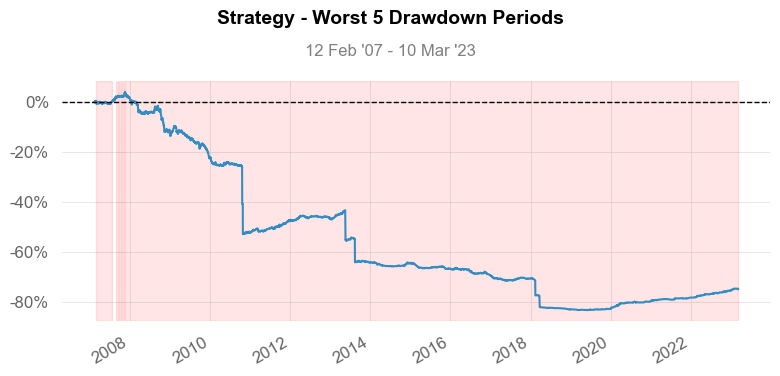

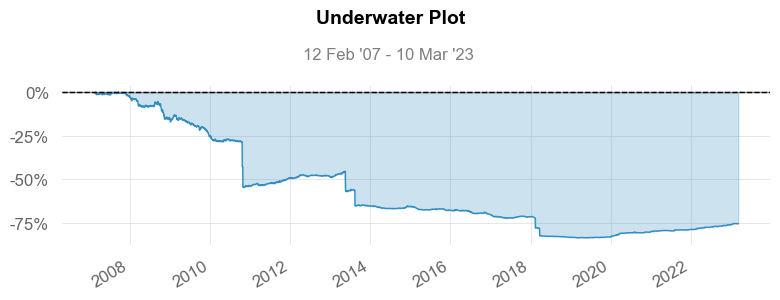

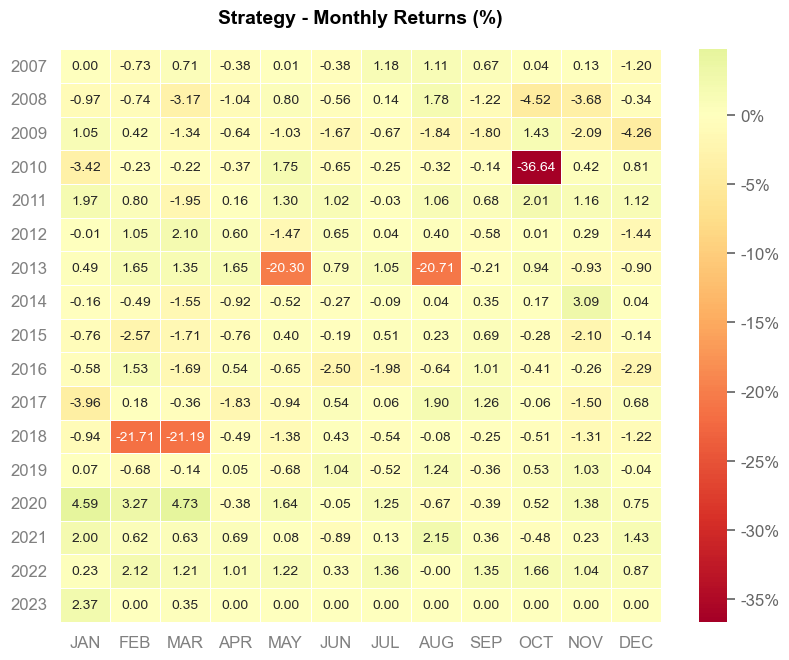

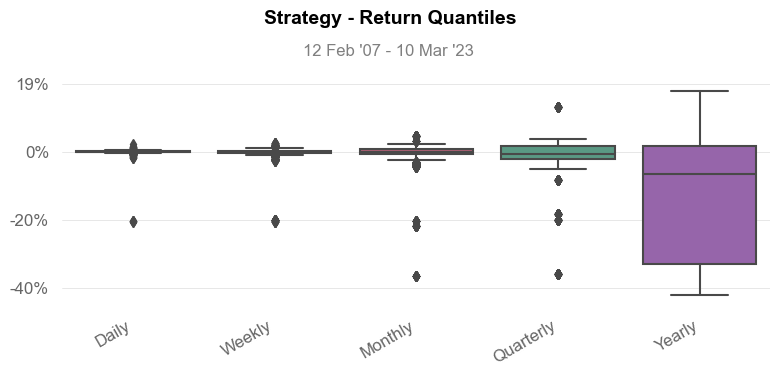

In [37]:
qs.reports.full(result['returns_all'].resample('D').last().dropna())

## TF H30

In [38]:
TF = 'M30'

In [39]:
data_1 = XAUUSD[TF]

In [40]:
data_2 = pd.read_csv(
    PATH_DATA + f'/{Currency_Pair}/{Currency_Pair}_{TF} - {Currency_Pair}_{TF}' + '.csv', index_col='Time', parse_dates=True)

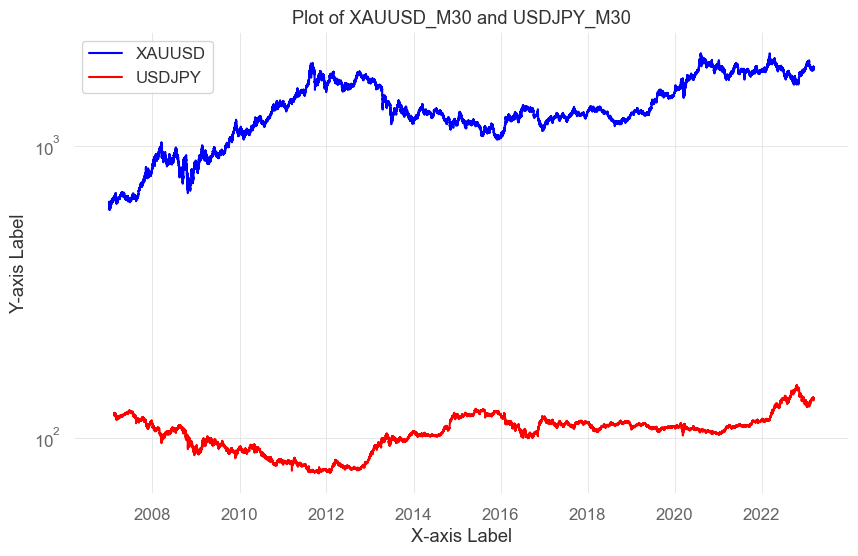

In [41]:
plt.figure(figsize=(10, 6))

# พล็อตข้อมูลใน data_1
plt.plot(data_1.index, data_1['Close'], label='XAUUSD', color='blue')
plt.yscale('log')  # ใช้ค่าลอการิทึมในแกน y

# พล็อตข้อมูลใน data_2
plt.plot(data_2.index, data_2['Close'], label=f'{Currency_Pair}', color='red')
plt.yscale('log')  # ใช้ค่าลอการิทึมในแกน y

# เพิ่มคำอธิบายแต่ละแท่งของกราฟ
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title(f'Plot of XAUUSD_{TF} and {Currency_Pair}_{TF}')
plt.legend()

# แสดงกราฟ
plt.show()

In [42]:
KF = Kalman_Filter(data_1, data_2)

In [43]:
KF.Stat()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Close   R-squared (uncentered):                   0.922
Model:                            OLS   Adj. R-squared (uncentered):              0.922
Method:                 Least Squares   F-statistic:                          2.380e+06
Date:                Sat, 02 Mar 2024   Prob (F-statistic):                        0.00
Time:                        18:05:23   Log-Likelihood:                     -1.4753e+06
No. Observations:              200000   AIC:                                  2.951e+06
Df Residuals:                  199999   BIC:                                  2.951e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Close         12.5932      0.008   1542.707      0.000      12.577      12.609
==============================================================================
Omnibus:                     2560.941   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1547.398
Skew:                          -0.018   Prob(JB):                         0.00
Kurtosis:                       2.571   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
result = KF.Run()

### Save Result Backtest 

In [45]:
result
data = result[['strategy', 'stock1_signal', 'stock2_signal']].copy()

In [46]:
filename = f'{Currency_Pair}_{TF}.csv'

In [47]:
data.to_csv(
    f'../../out/Pairs_Trading/Kalman Filter/Backtest/{filename}', index=True)

### Reports

                           Strategy
-------------------------  ----------
Start Period               2007-02-12
End Period                 2023-03-10
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          -68.05%
CAGR﹪                     -4.78%

Sharpe                     -0.44
Prob. Sharpe Ratio         0.08%
Smart Sharpe               -0.44
Sortino                    -0.45
Smart Sortino              -0.44
Sortino/√2                 -0.31
Smart Sortino/√2           -0.31
Omega                      0.71

Max Drawdown               -73.74%
Longest DD Days            5550
Volatility (ann.)          11.32%
Calmar                     -0.06
Skew                       -27.25
Kurtosis                   770.51

Expected Daily %           -0.02%
Expected Monthly %         -0.59%
Expected Yearly %          -6.49%
Kelly Criterion            -20.84%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.19%
Expected Shortfall (cVaR)  -1.19%

Max Conse

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-12-30,2018-12-24,2023-03-10,5550,-73.739662,-73.680586
2,2007-02-14,2007-04-23,2007-07-24,161,-1.838681,-1.620485
3,2007-11-20,2007-12-02,2007-12-21,32,-1.011176,-0.969660
4,2007-10-17,2007-10-29,2007-11-11,26,-0.744780,-0.730172
5,2007-08-28,2007-09-25,2007-10-12,46,-0.591683,-0.585601


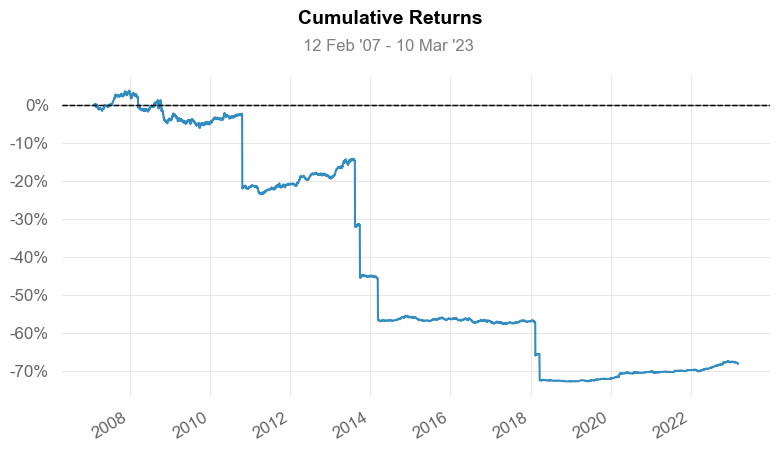

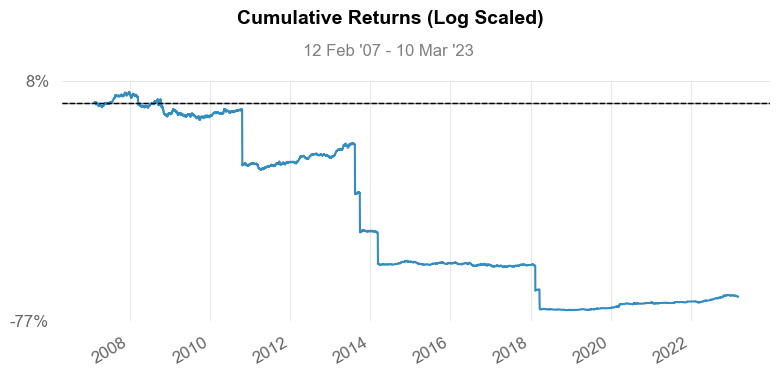

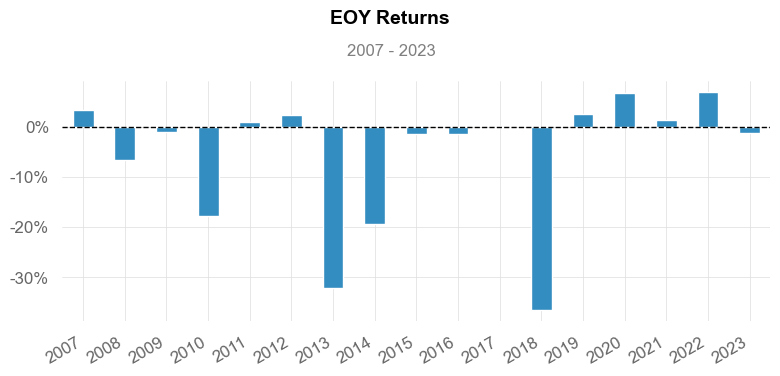

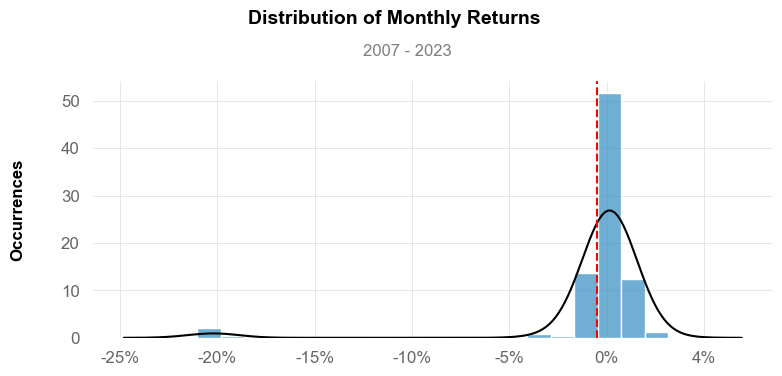

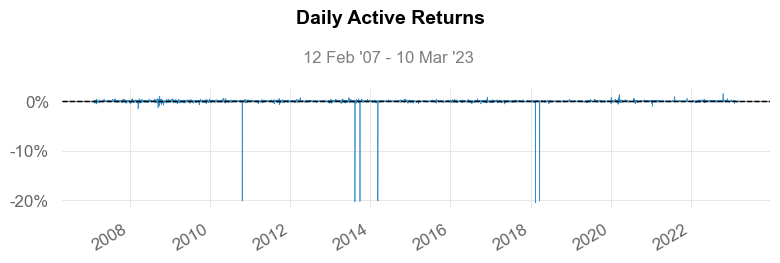

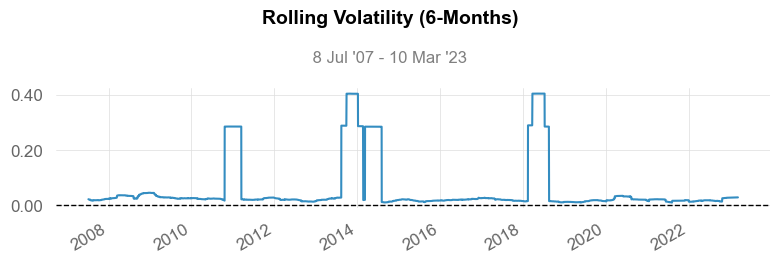

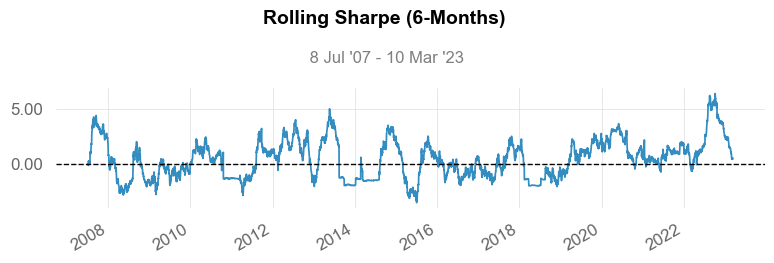

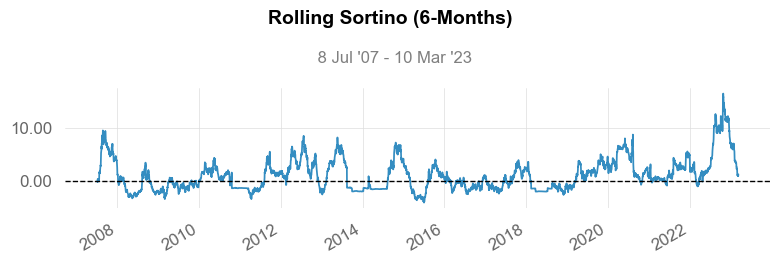

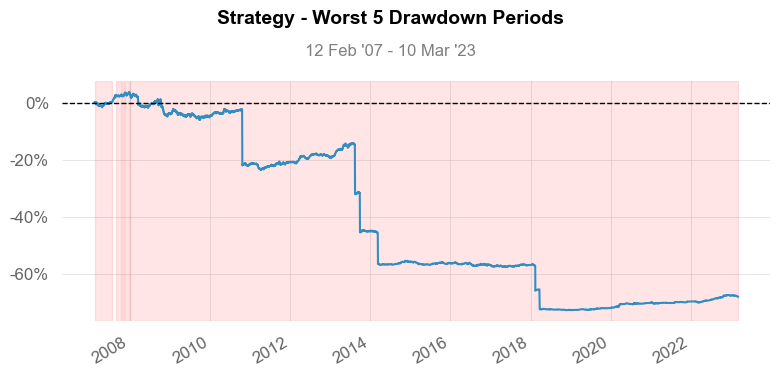

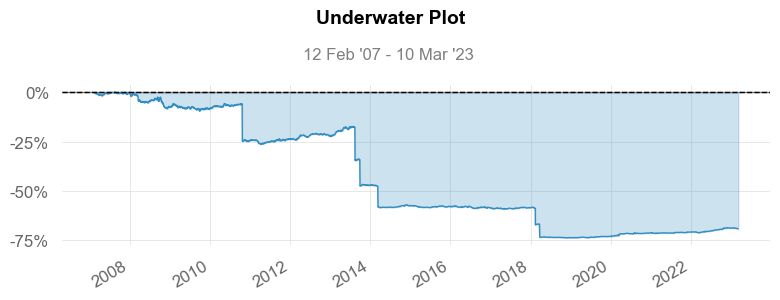

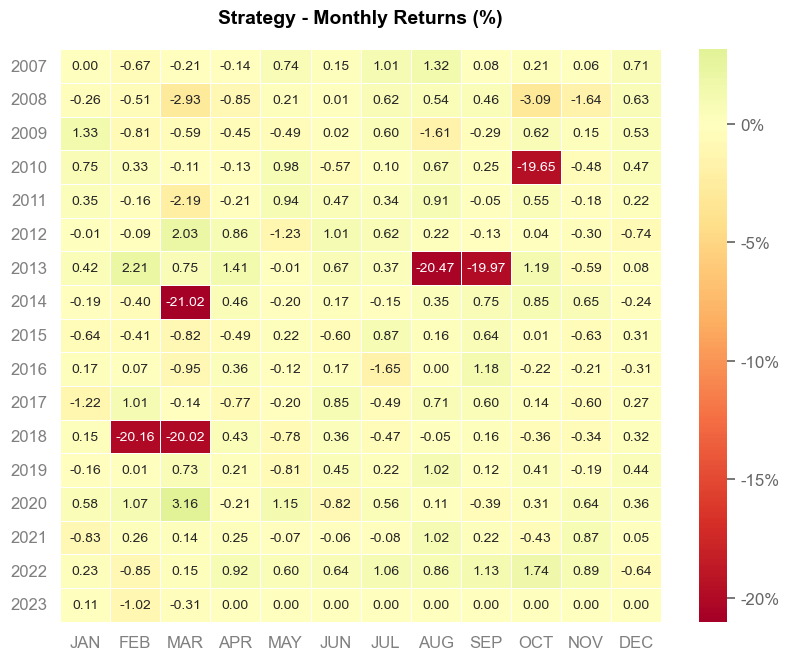

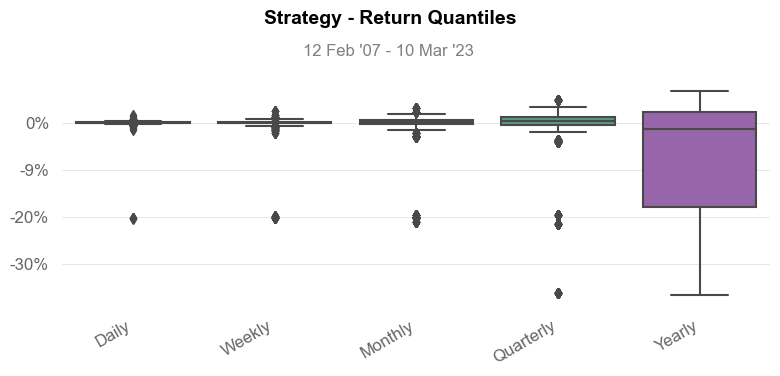

In [48]:
qs.reports.full(result['returns_all'].resample('D').last().dropna())